In [72]:
import numpy as np # le s
from matplotlib import pyplot as plt
from functools import lru_cache
import functools
import sys
import gc

np.random.seed(1)
np.random.uniform()

0.417022004702574

In [107]:
def reset_cache():
    wrappers = [
    a for a in gc.get_objects() 
    if isinstance(a, functools._lru_cache_wrapper)]

    for wrapper in wrappers:
        wrapper.cache_clear()
        
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print ('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

# Modélisation du comportement d'une ruche
Nous faisons les hypothèses suivantes concernant le fonctionnement d'une ruche :
 - Le nombre d'oeufs ponduent par la reine dépend de la saison, du nombre de cellules restantes dans la ruche et de l'age de la reine
 - Si les conditions de la ruche sont optimales, la mortalité des abeilles est connue, et est régulée en fonction de la saison principalement
 - La survavilité des bébés dépend de la ruche (pollen, nurse to brood ratio)
 - Les conditions de la ruche sont très fortement impactées par la météo
 
## L'importance de la météo et la saison sur le modèle
Le fonctionnement de la ruche tourne beaucoup autour de la météo et du pollen. La fonction season(t) nous permet de prendre en compte ce phénomène.

$$
\text { season }(t)=\max \left\{\begin{array}{l}
1-\frac{1}{1+x_{1} e^{-2 t / x_{2}}} \\
\frac{1}{1+x_{3} e^{-2\left(t-x_{4}\right) / x_{5}}}
\end{array}\right.
$$

Les variables $x_1, x_2, x_3, x_4, x_5$ varient la cette fonction.
 - $x_4$ est le jour de l'année où la reine pond le plus

In [3]:
CELLShive = 250000
SUPthreshold = 0.2
ELRstochrange = 0.01
ELRbase = 1600

LIFESPANegg = 3
MORTALITYeggs = 0.03

LIFESPANlarva = 5
MORTALITYlarvae = 0.01

LIFESPANpupa = 12
MORTALITYpupae = 0.001

FACTORothertasks = 0.2

NEEDnurses_per_pupa = .33
NEEDnurses_per_egg = .33
NEEDnurses_per_larva = lambda i: [.1,.5,.75,1.75,3][i]

POLLENNEEDadult = .0065
POLLENNEEDnurse = .00087
POLLENNEEDlarva = lambda i: [.001,.003 , .006, .012, .027][i]

CANNIBALISMhungerbase = lambda i: [.23,.3,.58,.06,0][i - 1]

FACTORpollenstorage = 6
FACTORforagingsuccess = .8
FACTORminpollenforagers = .01
FACTORforagingmax = .33
FACTORpollensavingmax = .3

NECTARNEEDlarva = lambda i: [.006,.018,.04,.09,.185][i]
NECTARNEEDadult = .055
NECTARNEEDnurse = .267
NECTARNEEDactiveforager = .2

LOADpollenforager = .06

LOADnectarforager = .04
TURNSnectarforager = 15

ProcessorsPerCell = 2
RATIOnectar_to_honey = .4
FACTORothertasks = .2

MORTALITYnursing = .005
MORTALITYprocessing = .005
MORTALITYforaging = .035
MORTALITYadultbase = 0.01

swd = 140

BEESadultbase = 123962

# les valeurs _t0 sont des valeurs experiementales
# que l'on prend en regardant les graphs ou experimentalement
INITpollen = 0
INITnectar = 0
INIThoney = 5000
STOCHASTIC_FACTOR = True

w_hivebase = 14000
w_cellsbase = .037
w_pollen = .23
w_nectar = .5
w_larva = lambda i: [.0002,.00059,.00331,.0644,.16][i-1]
w_honey = .5
w_egg = .0001
w_pupa = .16
w_adult = .1

In [280]:
RAIN = np.zeros(366)
TEMP = np.zeros(366)

tempAll = np.loadtxt('2018ParisTemp.txt', unpack=True, skiprows=0)

count = 8
i=0
while i<len(TEMP):
    TEMP[i] = np.average(tempAll[count:count+16])
    i+=1
    count+=25

# celcius
TEMP = (TEMP-32.)*(5/9)
#print(TEMP)

In [351]:
# x le vecteur des parametres x1, x2, ..., x5
@lru_cache(maxsize=None)
def season(t, x = [385, 30, 36, 115, 30]):
    return max(1 - 1 / (1 + x[0] * np.exp(-2 * t / x[1])), 1 / (1 + x[2] * np.exp(-2 * (t - x[3]) / x[4])))

# (page 5, eq 2)
@lru_cache(maxsize=None)
def CELLSempty(t):
    a, b, c, d = CELLSbrood(t), STORESpollen(t), STORESnectar(t), STOREShoney(t)
    return CELLShive - CELLSbrood(t) - STORESpollen(t) - STORESnectar(t) - STOREShoney(t)

# (page 5, eq 3)
@lru_cache(maxsize=None)
def SUPcomb(t):
    a = CELLSempty(t)
    if (a / (CELLShive + 1) < SUPthreshold):
        return CELLSempty(t) / (CELLShive + 1) * SUPthreshold
    else:
        return 1.

# (page 5, eq 4)
def ELRstoch(t):
    value = np.random.uniform(-ELRstochrange, ELRstochrange)
    return value

# (page 5, eq 5)
@lru_cache(maxsize=None)
def ELR(t):
    a = ELRstoch(t)
    value = ELRbase * (1 + a) * (1 - season(t)) * SUPcomb(t)
    return value


@lru_cache(maxsize=None)
def EGGS(i, t):
    if t==0:
        return 0 #INITeggs[i-1]
    if t<=0:
        print('This should not have been called')
        return None
    if i ==1:
        a, b = ELR(t-1), (1-MORTALITYeggs)
        value = a * b
    elif (i==2 or i==3):
        value = EGGS(i-1, t-1)*(1-MORTALITYeggs)
    elif i>3:
        print('These are no longer eggs. It should have called the Larvae function')
        return None
    return value

# (page 5, eq 7)
@lru_cache(maxsize=None)
def CELLSeggs(t):
    return np.sum([EGGS(i + 1, t) for i in range(LIFESPANegg)])

In [291]:
# (page 6, eq 9)
@lru_cache(maxsize=None)
def SURVIVALlarvae(i, t):
    return (1 - CANNIBALISMlarvae(i, t)) * (1 - MORTALITYlarvae)

# (page 6, eq 10)
@lru_cache(maxsize=None)
def CANNIBALISMlarvae(i, t):
    if t == 0:
        return 0
    return CANNIBALISMhungerbase(i) * (1 - (INDEXpollensituation(t - 1) * INDEXnursingquality(t - 1)))

# (page 6, eq 11)
@lru_cache(maxsize=None)
def LARVAE(i, t):
    if t == 0:
        return 0
    if i == 1:
        return EGGS(LIFESPANegg, t - 1) * SURVIVALlarvae(1, t)
    elif i<=LIFESPANlarva:
        return LARVAE(i - 1, t - 1) * SURVIVALlarvae(i, t)
    else:
        raise Exception("LARVAE age error")

# (page 6, eq 14)
@lru_cache(maxsize=None)
def PUPAE(i, t):
    if t == 0:
        return 0
    if i == 1:
        return LARVAE(LIFESPANlarva, t - 1) * (1 - MORTALITYpupae)
    else:
        return PUPAE(i - 1, t - 1) * (1 - MORTALITYpupae)
    
# (page 6, eq 15)
@lru_cache(maxsize=None)
def CELLSpupae(t):
    return np.sum([PUPAE(i + 1, t) for i in range(LIFESPANpupa)])

# (page 6, eq 17)
@lru_cache(maxsize=None)
def CELLSbrood(t):
    a, b, c = CELLSeggs(t), CELLSlarvae(t), CELLSpupae(t)
    return CELLSeggs(t) + CELLSlarvae(t) + CELLSpupae(t)

# (page 6, eq 12)
@lru_cache(maxsize=None)
def CELLSlarvae(t):
    return np.sum([LARVAE(i + 1, t) for i in range(LIFESPANlarva)])

In [347]:
# (page 7, eq 18)
@lru_cache(maxsize=None)
def MORTALITYadult(t):
    if t == 0:
        return MORTALITYadultbase
    
    NURSErate = MORTALITYnursing*(NURSES(t-1)/(BEESadult(t-1)+1))
    PROCESSORrate = MORTALITYprocessing*(PROCESSORS(t-1)/(BEESadult(t-1)+1))
    FORAGERrate = MORTALITYforaging*(FORAGERSactive(t-1)/(BEESadult(t-1)+1))

    value = MORTALITYadultbase + NURSErate + PROCESSORrate + FORAGERrate
    return value

@lru_cache(maxsize=None)
def BEESswarm(t):
    if t == swd:
        return BEESadult(t - 1) * 0.6
    else:
        return 0

# page 7, eq 19
@lru_cache(maxsize=None)
def BEESadult(t):
    if t == 0:
        return BEESadultbase
    return (BEESadult(t - 1) + PUPAE(LIFESPANpupa, t - 1)) * (1 - MORTALITYadult(t))

In [284]:
# page 7, eq 20
@lru_cache(maxsize=None)
def INDEXrain(t):
    return 1 - RAIN[t]

@lru_cache(maxsize=None)
def HOURSraining_during_daylight(t):
    return 0

@lru_cache(maxsize=None)
def HOURSdaylight(t):
    return 12

# page 7, eq 22
@lru_cache(maxsize=None)
def INDEXtemperature(t):
    temp = TEMP[t]
    if temp > 14 and temp <= 22:
        return (temp - 14) / 8
    if temp > 22 and temp <= 32:
        return 1
    if temp > 32 and temp <= 40:
        return (40 - temp) / 8
    else:
        return 0

# page 7, eq 23
@lru_cache(maxsize=None)
def INDEXflight(t):
    return INDEXrain(t) * INDEXtemperature(t)

# page 8, eq 24
@lru_cache(maxsize=None)
def INDEXnectaroutside(t):
    return min((1 - season(t)) * 1.5, 1)

# page 8, eq 25
@lru_cache(maxsize=None)
def INDEXpollenoutside(t):
    return min((1 - season(t)) * 1.5, 1)

In [285]:

# page 8, eq 26
@lru_cache(maxsize=None)
def NEEDworkers(t):
    return NEEDnurses(t) + NEEDpollenforagers(t)

# page 8, eq 27
@lru_cache(maxsize=None)
def RATIOworkforce(t):
    return min(BEESadult(t) * (1 - FACTORothertasks) / (NEEDworkers(t) + 1), 1)

# page 8, eq 28
@lru_cache(maxsize=None)
def NEEDnurses(t):
    value = np.sum([LARVAE(i + 1, t) * NEEDnurses_per_larva(i) for i in range(LIFESPANlarva)]) + CELLSeggs(t) * NEEDnurses_per_egg + CELLSpupae(t) * NEEDnurses_per_pupa 
    return value

# page 8, eq 29
@lru_cache(maxsize=None)
def NURSES(t):
    a, b = NEEDnurses(t), RATIOworkforce(t)
    value = a * b
    return value

# page 8, eq 30
@lru_cache(maxsize=None)
def INDEXnursingquality(t):
    return NURSES(t) / (NEEDnurses(t) + 1)

In [320]:
# page 9, eq 31
@lru_cache(maxsize=None)
def FORAGERS(t):
    return FORAGERSpollen(t) + FORAGERSnectar(t)

# page 9, eq 32
@lru_cache(maxsize=None)
def FORAGERSactive(t):
    return FORAGERSpollenactive(t) + FORAGERSnectaractive(t)

# page 9, eq 33
@lru_cache(maxsize=None)
def NEEDpollen(t):
    if t < 0:
        raise Exception("NEEDpollen t<0")
    return NEEDpollen_larvae(t) + NEEDpollen_adult(t)

# page 9, eq 34
@lru_cache(maxsize=None)
def NEEDpollen_larvae(t):
    return np.sum([POLLENNEEDlarva(i) * LARVAE(i + 1, t) for i in range(LIFESPANlarva)])

# page 9, eq 35
@lru_cache(maxsize=None)
def NEEDpollen_adult(t):
    return BEESadult(t) * POLLENNEEDadult + NURSES(t) * POLLENNEEDnurse

# page 9, eq 36
@lru_cache(maxsize=None)
def NEEDpollenincome(t):
    if t == 0:
        avg = 0
    else:
        avg = np.sum([NEEDpollen(t - d) for d in range(0, 2)]) / 3
    tmp = avg * FACTORpollenstorage - STORESpollen(t)
    return max(tmp, 0)

# page 9, 37
@lru_cache(maxsize=None)
def NEEDpollenforagers(t):
    if t == 0:
        return NEEDpollenincome(0) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)
    return NEEDpollenincome(t - 1) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)


In [317]:
# page 10, eq 38
@lru_cache(maxsize=None)
def FORAGERSpollen(t):
    a = NEEDpollenforagers(t) * RATIOworkforce(t)
    b = (BEESadult(t) - NURSES(t)) * FACTORminpollenforagers
    c = BEESadult(t) * FACTORforagingmax
    return min(max(a, b), c)

# page 10, eq 39
@lru_cache(maxsize=None)
def FORAGERSpollenactive(t):
    return FORAGERSpollen(t) * INDEXflight(t) * INDEXpollenoutside(t)

# page 10, eq 40
@lru_cache(maxsize=None)
def NEEDnectar(t):
    return NEEDnectar_larvae(t) + NEEDnectar_adult(t)

# page 10, eq 41
@lru_cache(maxsize=None)
def NEEDnectar_larvae(t):
    return np.sum([NECTARNEEDlarva(i) * LARVAE(i + 1, t) for i in range(LIFESPANlarva)])

# page 10, eq 42
@lru_cache(maxsize=None)
def NEEDnectar_adult(t):
    return BEESadult(t) * NECTARNEEDadult + NURSES(t) * NECTARNEEDnurse + FORAGERSactive(t) * NECTARNEEDactiveforager

# page 10, eq 43
@lru_cache(maxsize=None)
def WORKFORCEnectar(t):
    if RATIOworkforce(t) == 1:
        return (BEESadult(t) * (1 - FACTORothertasks)) - NURSES(t) - FORAGERSpollen(t)
    else:
        return 0
    
# page 10, eq 44
@lru_cache(maxsize=None)
def FORAGERSnectar(t):
    a = (BEESadult(t) * FACTORforagingmax) - FORAGERSpollen(t)
    b = WORKFORCEnectar(t) - PROCESSORS(t)
    
    return min(a, b)

# page 10, eq 45
@lru_cache(maxsize=None)
def FORAGERSnectaractive(t):
    return FORAGERSnectar(t) * INDEXflight(t) * INDEXnectaroutside(t)

In [316]:
# page 11, eq 46
@lru_cache(maxsize=None)
def INCOMEpollen(t):
    return FORAGERSpollenactive(t) * LOADpollenforager * TURNSpollenforager * FACTORforagingstoch(t) * FACTORforagingsuccess

# page 11, eq 47
@lru_cache(maxsize=None)
def FACTORforagingstoch(t):
    if STOCHASTIC_FACTOR:
        return np.random.uniform(0.75, 1.25)
    else:
        return 1

# page 11, eq 48
@lru_cache(maxsize=None)
def INDEXpollensituation(t):
    return min(1, STORESpollen(t) / (NEEDpollen(t) * FACTORpollenstorage + 1))

# page 11, eq 49
@lru_cache(maxsize=None)
def INCOMEnectar(t):
    a = FORAGERSnectaractive(t) * LOADnectarforager * TURNSnectarforager * FACTORforagingstoch(t) * FACTORforagingsuccess
    b = CELLSempty(t - 1)
    return min(a, b)

# page 11, eq 50
@lru_cache(maxsize=None)
def NEEDprocessors(t):
    return STORESnectar(t - 1) * ProcessorsPerCell

# page 11, eq 51
@lru_cache(maxsize=None)
def PROCESSORS(t):
    return min(NEEDprocessors(t), WORKFORCEnectar(t))

# page 11, eq 52
@lru_cache(maxsize=None)
def PROCESSEDnectar(t):
    return min(STORESnectar(t - 1) - USAGEnectar(t), PROCESSORS(t) / ProcessorsPerCell)

In [312]:
# page 12, eq 53
@lru_cache(maxsize=None)
def USAGEpollen(t):
    if t == 0:
        a = STORESpollen(t)
        b = NEEDpollen(0) * (1 - (FACTORpollensavingmax * (1 - INDEXpollensituation(0))))
        return min(a, b)
    a = STORESpollen(t - 1)
    b = NEEDpollen(t - 1) * (1 - (FACTORpollensavingmax * (1 - INDEXpollensituation(t - 1))))
    return min(a, b)

# page 12, eq 54
@lru_cache(maxsize=None)
def STORESpollen(t):
    if t == 0:
        return INITpollen
    return STORESpollen(t - 1) + INCOMEpollen(t) - USAGEpollen(t)

# page 12, eq 55
@lru_cache(maxsize=None)
def USAGEnectar(t):
    if t == 0:
        return min(STORESnectar(0), NEEDnectar(t)) 
    return min(STORESnectar(t - 1), NEEDnectar(t))

# page 12, eq 56
@lru_cache(maxsize=None)
def USAGEhoney(t):
    if t == 0:
        return min(STOREShoney(0), (NEEDnectar(t) - USAGEnectar(t)) * RATIOnectar_to_honey)
    return min(STOREShoney(t - 1), (NEEDnectar(t) - USAGEnectar(t)) * RATIOnectar_to_honey)

# page 12, eq 57
@lru_cache(maxsize=None)
def STORESnectar(t):
    if t <= 0:
        return INITnectar
    return STORESnectar(t - 1) + INCOMEnectar(t) - USAGEnectar(t) - PROCESSEDnectar(t)

# page 12, eq 58
@lru_cache(maxsize=None)
def STOREShoney(t):
    if t == 0:
        return INIThoney
    return STOREShoney(t - 1) - USAGEhoney(t) + (PROCESSEDnectar(t) * RATIOnectar_to_honey)

# page 12, eq 59
@lru_cache(maxsize=None)
def WEIGHTcolony(t):
    tmp = np.sum([w_larva(i) * LARVAE(i + 1, t) for i in range(LIFESPANlarva)])
    return 1/1000 * (w_hivebase + w_cellsbase * CELLShive + w_pollen * STORESpollen(t) + w_nectar * STORESnectar(t) + w_honey * STOREShoney(t) + w_egg * CELLSeggs(t) + w_pupa * CELLSpupae(t) + tmp + w_adult * BEESadult(t))

# page 13, eq 60
@lru_cache(maxsize=None)
def BEESlazy(t):
    return (BEESadult(t) * (1 - FACTORothertasks)) - FORAGERSactive(t) - NURSES(t) - PROCESSORS(t)

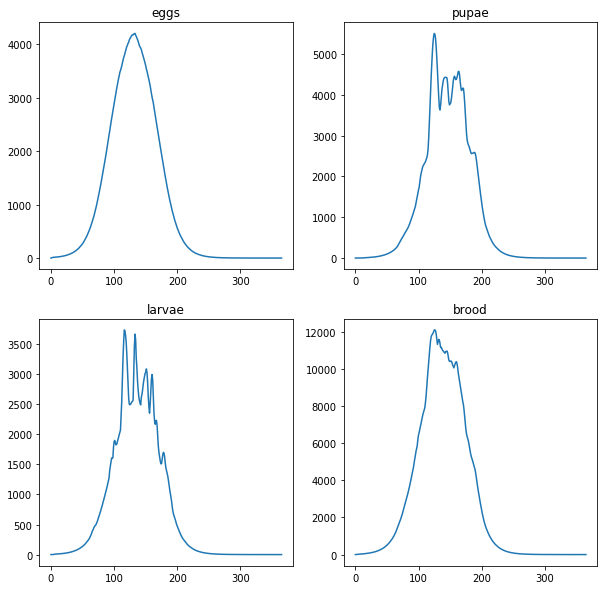

In [353]:
reset_cache()
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

a, b, c, d = [], [], [], []

time = np.arange(366)

for t in time:
    a.append(CELLSeggs(t))
    b.append(CELLSlarvae(t))
    c.append(CELLSpupae(t))
    d.append(CELLSbrood(t))

ax[0,0].plot(a)
ax[0,0].title.set_text("eggs")
ax[1,0].plot(b)
ax[1,0].title.set_text("larvae")
ax[0,1].plot(c)
ax[0,1].title.set_text("pupae")
ax[1,1].plot(d)
ax[1,1].title.set_text("brood")
plt.show()

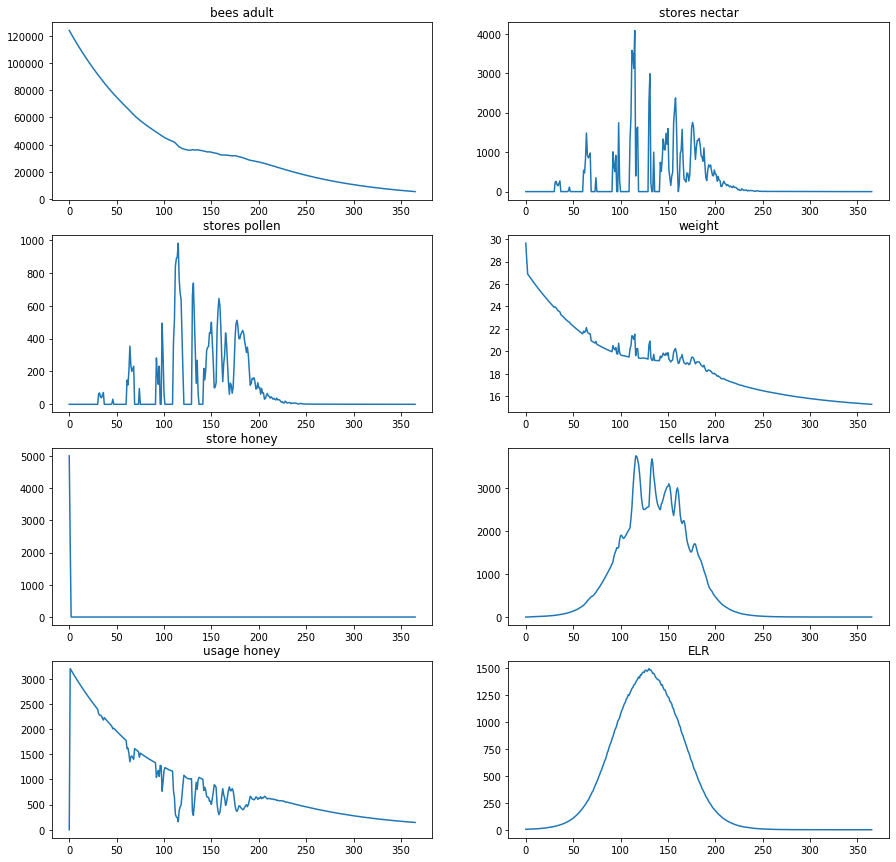

In [354]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

a, b, c, d, e, f, g, h = [], [], [], [], [], [], [], []

time = np.arange(366)

for t in time:
    a.append(BEESadult(t))
    b.append(STORESpollen(t))
    c.append(STORESnectar(t))
    d.append(WEIGHTcolony(t))
    e.append(STOREShoney(t))
    f.append(CELLSlarvae(t))
    g.append(NEEDpollenincome(t))
    h.append(ELR(t))

ax[0,0].plot(a)
ax[0,0].title.set_text("bees adult")
ax[1,0].plot(b)
ax[1,0].title.set_text("stores pollen")
ax[0,1].plot(c)
ax[0,1].title.set_text("stores nectar")
ax[1,1].plot(d)
ax[1,1].title.set_text("weight")
ax[2,0].plot(e)
ax[2,0].title.set_text("store honey")
ax[2,1].plot(f)
ax[2,1].title.set_text("cells larva")
ax[3,0].plot(g)
ax[3,0].title.set_text("usage honey")
ax[3,1].plot(h)
ax[3,1].title.set_text("ELR")
plt.show()